In [1]:
import json
import random
from geopy.distance import geodesic
import numpy as np
import datetime

def calculate_average_location(coords):
    if not coords:
        return None

    sum_lat = 0
    sum_lon = 0
    count = 0

    for coord in coords:
        if coord and len(coord) == 2:
            sum_lat += coord[0]
            sum_lon += coord[1]
            count += 1

    if count == 0:
        return None

    return [sum_lat / count, sum_lon / count]

def calculate_condition_value(activity):
    # Extracting start and end coordinates
    start_coords = activity.get('start_latlng', [])
    end_coords = activity.get('end_latlng', [])
    # Combining the start and end coordinates for distance calculation 
    coords = []
    if start_coords:
        coords.append(start_coords)
    if end_coords:
        coords.append(end_coords)

    if not coords:
        return None

    avg_heart_rate = activity['average_heartrate']
    avg_speed = activity['average_speed']*3.6
    # heart_rate_variability = np.std(activity['heart_rate'])

    if avg_heart_rate == 0:
        return None

    distance = activity['distance'] / 1000
    # start_time = datetime.datetime.fromtimestamp(activity['timestamp'][0])
    # end_time = datetime.datetime.fromtimestamp(activity['timestamp'][-1])
    # duration = (end_time - start_time).total_seconds() / 3600
    duration = activity['elapsed_time'] / 3600
    if duration == 0:
        return None

    condition_value = (avg_speed * distance) / (avg_heart_rate * duration)
    return condition_value

file_path = '../Data/Andere/filtered_strava_document.json'
with open(file_path, 'r') as f:
    data = json.load(f)


# Initialize lists to store activity data
activity_ids = []
speeds = []
distances = []
average_heartrates = []
altitude_changes = []
locations = []
condition_values = []

for activity in data:
    # Filter alleen activiteiten van het type "Run"
    if activity.get('sport_type') == 'Run':
        activity_ids.append(activity['id'])
        speeds.append(activity.get('average_speed', 0) * 3.6)
        distances.append(activity.get('distance', 0) / 1000.0)
        average_heartrates.append(activity.get('average_heartrate', 0))
        altitude_changes.append(activity.get('total_elevation_gain', 0))

        coords = activity.get('start_latlng', [])
        if coords:
            locations.append(coords)
        condition_value = calculate_condition_value(activity)
        if condition_value:
            condition_values.append(condition_value)

average_speed = np.mean(speeds) if speeds else 0
std_speed = np.std(speeds) if speeds else 0
average_distance = np.mean(distances) if distances else 0
std_distance = np.std(distances) if distances else 0
average_average_heartrate = np.mean(average_heartrates) if average_heartrates else 0
std_average_heartrate = np.std(average_heartrates) if average_heartrates else 0
average_altitude_change = np.mean(altitude_changes) if altitude_changes else 0
std_altitude_change = np.std(altitude_changes) if altitude_changes else 0
average_condition_value = np.mean(condition_values) if condition_values else 0
std_condition_value = np.std(condition_values) if condition_values else 0


# Calculate average location
average_location = calculate_average_location(locations) if locations else [0, 0]

# Calculate weights
total_std = (1/(std_distance+0.0001)) + (1/(std_altitude_change+0.0001)) + (1/(std_condition_value+0.0001))
weight_std_distance = (1/(std_distance+0.0001)) / total_std
weight_std_altitude_change = (1/(std_altitude_change+0.0001)) / total_std
weight_std_condition_value = (1/(std_condition_value+0.0001)) / total_std

# Construct the final JSON object
result_json = {
    "userId": 1,
    "activity_ids": activity_ids,
    "speeds": speeds,
    "distances": distances,
    "average_heartrates": average_heartrates,
    "altitude_changes": altitude_changes,
    "locations": locations,
    "condition_values": condition_values,
    "average_location": average_location,
    "average_speeds": average_speed,
    "std_speeds": std_speed,
    "average_distances": average_distance,
    "std_distances": std_distance,
    "average_average_heartrates": average_average_heartrate,
    "std_average_heartrates": std_average_heartrate,
    "average_altitude_changes": average_altitude_change,
    "std_altitude_changes": std_altitude_change,
    "weight_std_distance": weight_std_distance,
    "weight_std_altitude_change": weight_std_altitude_change,
    "weight_std_condition_value": weight_std_condition_value,
    "average_condition_value": average_condition_value,
    "std_condition_values": std_condition_value
}
output_file_path = '../Data/Andere/user_profile_strava.json'

# Sla het resultaat op in een JSON-bestand
with open(output_file_path, 'w') as outfile:
    json.dump(result_json, outfile)

print(f"Gebruikersprofiel opgeslagen als {output_file_path}")

Gebruikersprofiel opgeslagen als ../Data/Andere/user_profile_strava.json


Gewichten voor gebruiker 1: {'average_altitude_change': 0.0021222902008860003, 'average_distance': 0.029820236699909002, 'average_condition_value': 0.9680574730992031, 'distance_to_user': 1.0}


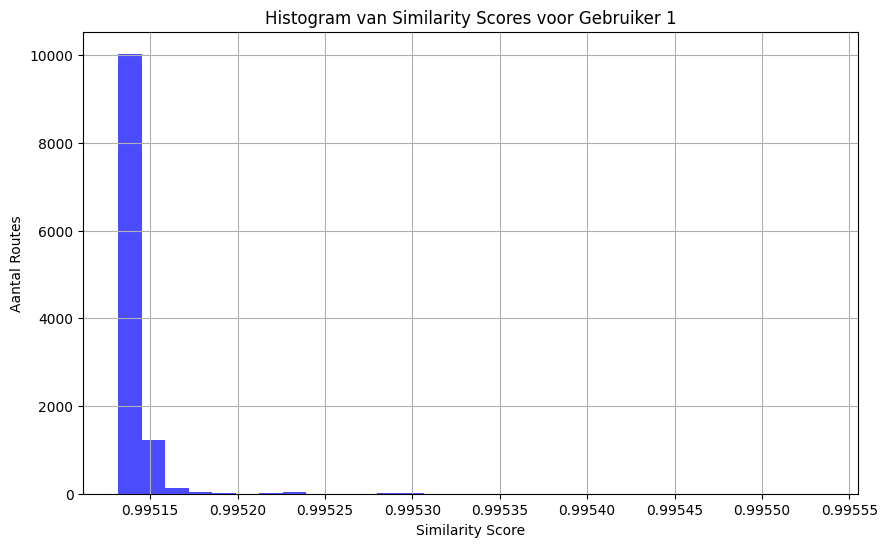

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,...,average_condition_value,mean_altitude,mean_latitude,mean_longitude,orig_altitude_change,orig_distance,orig_mean_altitude,orig_average_condition_value,distance_to_user,similarity_score
188,"[50.87643471546471, 50.876434464007616, 50.876...","[3.180931331589818, 3.180923452600836, 3.18086...","[22.4, 22.4, 22.4, 22.4, 22.4, 22.4, 22.2, 21....",run,115848511,"[112, 112, 117, 119, 123, 130, 135, 140, 145, ...","[1356914815, 1356914816, 1356914818, 135691482...","[2.3508, 2.3508, 3.24, 3.7584, 5.5584, 9.9288,...",0.089052,0.007010,...,0.079041,0.064887,50.872153,3.181271,26.8,8.679252,33.1168,0.104458,19.101375,0.995535
183,"[51.030279602855444, 51.030279602855444, 51.03...","[3.041570456698537, 3.041570456698537, 3.04157...","[22.6, 22.6, 22.6, 22.6, 22.6, 22.6, 22.6, 22....",run,161909020,"[129, 129, 135, 140, 145, 153, 157, 152, 152, ...","[1361737774, 1361737775, 1361737778, 136173777...","[7.5924, 8.0028, 8.5824, 9.0432, 10.0692, 11.1...",0.103136,0.007063,...,0.079041,0.063268,51.027923,3.043416,27.0,9.962000,21.2368,0.104458,37.737548,0.995341
8208,"[50.6849929690361, 50.684992130845785, 50.6849...","[3.139309147372842, 3.139311578124761, 3.13935...","[53.8, 53.8, 53.8, 52.8, 52.0, 51.4, 50.0, 48....",run,483910620,"[80, 80, 79, 85, 91, 96, 101, 109, 114, 119, 1...","[1409703126, 1409703126, 1409703128, 140970313...","[5.0544, 5.0544, 6.5988, 12.546, 13.608, 13.95...",0.085825,0.009103,...,0.037744,0.066807,50.689004,3.129106,34.8,8.385357,47.1980,0.054359,22.335968,0.995302
8211,"[50.68452165462077, 50.68447194993496, 50.6844...","[3.139223149046302, 3.13931149430573, 3.139386...","[46.4, 46.4, 46.4, 46.4, 46.4, 46.4, 46.4, 46....",run,483910800,"[68, 74, 79, 85, 91, 97, 102, 105, 113, 112, 1...","[1407800221, 1407800225, 1407800227, 140780023...","[2.6172, 4.8852, 6.3216, 8.118, 9.5292, 10.926...",0.085785,0.006435,...,0.037744,0.067063,50.688988,3.128914,24.6,8.381691,49.0744,0.054359,22.348839,0.995302
8214,"[50.68415377289057, 50.68415377289057, 50.6841...","[3.139372514560818, 3.139372514560818, 3.13939...","[37.6, 37.6, 37.6, 37.6, 37.6, 37.6, 37.6, 38....",run,321488630,"[99, 99, 99, 101, 109, 112, 116, 122, 127, 132...","[1378561839, 1378561839, 1378561840, 137856184...","[9.8784, 7.8012, 6.0084, 5.9616, 7.02, 7.0632,...",0.085964,0.007481,...,0.037744,0.066877,50.688987,3.128770,28.6,8.397950,47.7084,0.054359,22.357950,0.995302
8209,"[50.68501451052725, 50.68501476198435, 50.6849...","[3.1396745145320892, 3.13967065885663, 3.13972...","[89.2, 89.2, 89.2, 89.2, 89.8, 90.2, 90.4, 90....",run,483910634,"[87, 87, 89, 95, 100, 105, 109, 112, 115, 120,...","[1409530918, 1409530918, 1409530922, 140953092...","[3.708, 3.384, 3.7692, 4.734, 6.0516, 7.0632, ...",0.085126,0.015171,...,0.037744,0.067299,50.689088,3.128850,58.0,8.321689,50.8056,0.054359,22.347773,0.995302
8207,"[50.6844337284565, 50.6844337284565, 50.684430...","[3.139252569526434, 3.139256089925766, 3.13927...","[29.2, 29.2, 29.2, 30.0, 31.4, 32.6, 32.8, 33....",run,483910595,"[82, 82, 82, 86, 93, 98, 99, 103, 108, 113, 11...","[1410309683, 1410309683, 1410309684, 141030968...","[2.7576, 2.7936, 2.934, 5.1444, 7.6464, 8.8596...",0.076192,0.007376,...,0.037744,0.066551,50.688754,3.128357,28.2,7.507935,45.3180,0.054359,22.395772,0.995301
8222,"[50.684467339888215, 50.684464909136295, 50.68...","[3.139238404110074, 3.139257933944463, 3.13935...","[39.8, 39.8, 39.8, 39.8, 39.8, 40.0, 40.4, 41....",run,321490224,"[87, 87, 92, 94, 107, 112, 117, 125, 130, 132,...","[1366755862, 1366755863, 1366755866, 136675586...","[3.834, 3.7296, 5.0976, 5.8932, 9.3996, 10.494...",0.101978,0.010254,...,0.037744,0.067243,50.688277,3.130745,39.2,9.856537,50.3936,0.054359,22.270405,0.995301
8221,"[50.68454470485449, 50.68447873927653, 50.6844...","[3.139119632542133, 3.139265142381191, 3.13929...","[58.4, 58.4, 58.4, 58.2, 57.6, 57.0, 57.0, 56....",run,321490169,"[82, 88, 88, 96, 101, 111, 1

In [4]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import folium
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Stap 1: Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Stap 2: Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Bewaar de originele waarden in aparte kolommen
user_profiles_df['orig_average_speeds'] = user_profiles_df['average_speeds']
user_profiles_df['orig_average_altitude_changes'] = user_profiles_df['average_altitude_changes']
user_profiles_df['orig_average_distances'] = user_profiles_df['average_distances']
user_profiles_df['orig_average_condition_value'] = user_profiles_df['average_condition_value']

routes_df['orig_altitude_change'] = routes_df['altitude_change']
routes_df['orig_distance'] = routes_df['distance']
routes_df['orig_mean_altitude'] = routes_df['mean_altitude']
routes_df['orig_average_condition_value'] = routes_df['average_condition_value']

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = MinMaxScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Stap 3: Bepaal gewichten voor gebruikerskenmerken

gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Stap 4: Definieer aanbevelingsfunctie voor routes

def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, top_n=10):
    if user_id in gewichten:
        print(f"Gewichten voor gebruiker {user_id}: {gewichten[user_id]}")
    else:
        print(f"Geen gewichten gevonden voor gebruiker {user_id}")

    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])

    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        # print(distance_to_user)
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Functie om de cosine similarity te berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Bereken de gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        # Cosine similarity berekenen
        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]


    # Pas de cosine similarity functie toe en sla de score op
    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
# Selecteer de routes met de hoogste cosine similarity scores
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()
    # Stap 5: Creëer een kaart met de locatie van de gebruiker en de routes
    user_data = user_profiles_df[user_profiles_df['userId'] == sample_user_id].iloc[0]
    user_popup_info = f"UserID: {sample_user_id}<br>" \
                    f"Average Altitude Change: {user_data['orig_average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['orig_average_distances']}<br>" \
                    f"Average Condition Value: {user_data['orig_average_condition_value']}"


    mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicnVwYXR0eW4iLCJhIjoiY2xyaWU2NG9nMDd6dzJtcDhwMHp5NWV3biJ9.bHb-trK3I9Z0H2uWRSoWow'
    map_obj = folium.Map(location=user_location, zoom_start=12, tiles=mapbox_tileset, attr='Mapbox')
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Definieer een lijst met kleuren
    colors = ["red", "blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))
        route_color = colors[index % len(colors)]
        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Altitude Change: {route_data['orig_altitude_change']}<br>" \
                        f"Distance: {route_data['orig_distance']}<br>" \
                        f"Condition Value: {route_data['orig_average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj) 


    return recommended_routes



# Stap 6: Test de functie voor een specifieke gebruiker

sample_user_id = 1
# sample_user_id = 8899244
# sample_user_id = 3537163
# sample_user_id = 5325166
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)

recommended_routes.head(10)


Gewichten voor gebruiker 1: {'average_altitude_change': 0.0021222902008860003, 'average_distance': 0.029820236699909002, 'average_condition_value': 0.9680574730992031, 'distance_to_user': 1.0}
   userId                                       activity_ids  \
0       1  [7984032531, 8018296272, 8018281439, 804104864...   

                                              speeds  \
0  [12.4416, 12.520800000000001, 12.96, 13.1868, ...   

                                           distances  \
0  [6.0127, 8.0167, 6.054600000000001, 8.029, 7.1...   

                                  average_heartrates  \
0  [182.0, 183.0, 177.9, 127.1, 155.2, 175.4, 160...   

                                    altitude_changes  \
0  [7.9, 7.9, 7.8, 10.7, 14.7, 7.9, 7.8, 7.8, 7.9...   

                                           locations  \
0  [[50.85154583, 3.2763045], [50.852261, 3.27675...   

                                    condition_values  \
0  [0.8383631352986951, 0.848195853980057, 0.9440...   



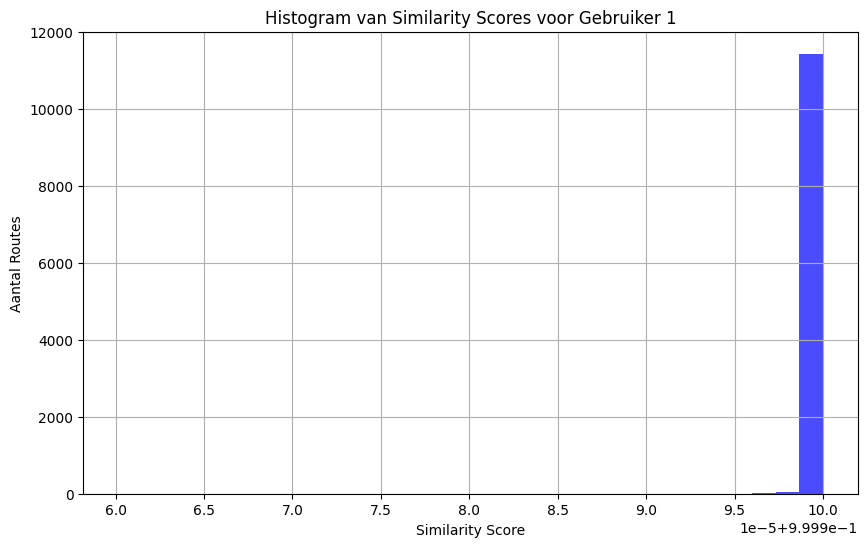

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,...,average_condition_value,mean_altitude,mean_latitude,mean_longitude,orig_altitude_change,orig_distance,orig_mean_altitude,orig_average_condition_value,distance_to_user,similarity_score
9115,"[20.60647811740637, 20.60647283680737, 20.6064...","[-100.38286202587187, -100.38286504335701, -10...","[1843.6, 1852.0, 1852.0, 1852.0, 1843.2, 1843....",run,362064549,"[90, 90, 90, 90, 90, 89, 90, 90, 90, 91, 92, 9...","[1402428107, 1402428108, 1402428109, 140242811...","[2.844, 2.844, 2.844, 2.844, 2.484, 2.484, 5.7...",0.012068,0.003610,...,0.021412,0.311437,20.606551,-100.383911,13.8,1.667583,1841.3916,0.034547,9181.644705,1.0
9062,"[20.626563923433423, 20.626622512936592, 20.62...","[-100.41514710523188, -100.41509530507028, -10...","[1908.2, 1909.0, 1909.0, 1909.0, 1901.0, 1901....",run,459306840,"[77, 77, 77, 77, 80, 81, 84, 85, 91, 92, 95, 9...","[1418685847, 1418685848, 1418685849, 141868585...","[2.664, 2.664, 2.664, 2.664, 4.284, 5.904, 7.4...",0.011238,0.006644,...,0.021412,0.318604,20.625319,-100.415425,25.4,1.591953,1893.9564,0.034547,9182.050819,1.0
9070,"[20.626670625060797, 20.626664087176323, 20.62...","[-100.41517116129398, -100.41517166420817, -10...","[1870.8, 1892.6, 1892.6, 1892.6, 1872.0, 1871....",run,459305596,"[89, 89, 89, 89, 87, 87, 87, 86, 84, 84, 84, 8...","[1414096291, 1414096293, 1414096294, 141409629...","[1.008, 1.008, 1.008, 1.008, 4.212, 5.832, 5.8...",0.011426,0.007952,...,0.021412,0.315317,20.626447,-100.415418,30.4,1.609080,1869.8460,0.034547,9181.952299,1.0
9061,"[20.626978492364287, 20.626967679709196, 20.62...","[-100.41484292596579, -100.41484108194709, -10...","[1883.8, 1879.8, 1879.8, 1884.4, 1884.2, 1883....",run,459306247,"[81, 81, 81, 84, 93, 97, 98, 99, 98, 98, 101, ...","[1418770200, 1418770202, 1418770204, 141877020...","[4.356, 4.356, 4.356, 5.976, 9.18, 9.036, 9.97...",0.016865,0.005912,...,0.021412,0.316320,20.625610,-100.415751,22.6,2.104504,1877.2048,0.034547,9182.046627,1.0
9060,"[20.627034567296505, 20.627032136544585, 20.62...","[-100.41498432867229, -100.4149891063571, -100...","[1889.8, 1884.8, 1884.8, 1889.8, 1889.6, 1889....",run,459307065,"[80, 80, 80, 86, 87, 90, 93, 97, 104, 108, 112...","[1418856007, 1418856009, 1418856011, 141885601...","[2.664, 2.664, 2.664, 5.868, 7.487999999999999...",0.018548,0.005598,...,0.021412,0.317198,20.625748,-100.415724,21.4,2.257786,1883.6416,0.034547,9182.032857,1.0
9067,"[20.62666442245245, 20.626659896224737, 20.626...","[-100.41501433588564, -100.41507879272103, -10...","[1864.8, 1905.6, 1905.6, 1863.8, 1864.8, 1865....",run,459305802,"[81, 81, 81, 81, 83, 84, 86, 88, 90, 92, 94, 9...","[1415484826, 1415484827, 1415484829, 141548483...","[8.676, 8.676, 8.676, 8.676, 11.88, 13.5, 16.4...",0.016079,0.012974,...,0.021412,0.314485,20.626513,-100.415346,49.6,2.032882,1863.7496,0.034547,9181.941941,1.0
9063,"[20.626609018072486, 20.626617902889848, 20.62...","[-100.4149751085788, -100.41496932506561, -100...","[1905.6, 1915.8, 1915.8, 1905.0, 1906.0, 1906....",run,459306114,"[77, 77, 77, 81, 86, 90, 94, 96, 98, 102, 105,...","[1416956017, 1416956018, 1416956020, 141695602...","[6.408, 6.408, 6.408, 8.028, 9.648, 12.024, 9....",0.019420,0.007115,...,0.021412,0.319483,20.625554,-100.415620,27.2,2.337153,1900.4068,0.034547,9182.042989,1.0
9069,"[20.626704655587673, 20.626682778820395, 20.62...","[-100.41488114744425, -100.41487209498882, -10...","[1874.6, 1853.0, 1853.0, 1874.4, 1874.4, 1874....",run,459306368,"[67, 67, 67, 75, 76, 79, 83, 85, 88, 94, 99, 1...","[1414183416, 1414183419, 1414183421, 141418342...","[5.148, 5.148, 5.148, 6.084, 8.208, 8.856, 9.2...",0.019655,0.006592,...,0.021412,0.315845,20.626459,-100.415568,25.2,2.358561,1873.7212,0.034547,9181.961019,1.0
9065,"[20.626606000587344, 20.626563588157296, 20.62...","[-100.41495113633573, -100.41501626372337, -10...","[1890.8, 1925.8, 1925.8, 1892.6, 1891.4, 1890....",run,459305894,"[74, 74, 7

In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import folium
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Andere/user_profile_strava.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Stap 1: Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Stap 2: Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Bewaar de originele waarden in aparte kolommen
user_profiles_df['orig_average_speeds'] = user_profiles_df['average_speeds']
user_profiles_df['orig_average_altitude_changes'] = user_profiles_df['average_altitude_changes']
user_profiles_df['orig_average_distances'] = user_profiles_df['average_distances']
user_profiles_df['orig_average_condition_value'] = user_profiles_df['average_condition_value']

routes_df['orig_altitude_change'] = routes_df['altitude_change']
routes_df['orig_distance'] = routes_df['distance']
routes_df['orig_mean_altitude'] = routes_df['mean_altitude']
routes_df['orig_average_condition_value'] = routes_df['average_condition_value']

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = MinMaxScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Stap 3: Bepaal gewichten voor gebruikerskenmerken

gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Stap 4: Definieer aanbevelingsfunctie voor routes

def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, top_n=10):
    if user_id in gewichten:
        print(f"Gewichten voor gebruiker {user_id}: {gewichten[user_id]}")
    else:
        print(f"Geen gewichten gevonden voor gebruiker {user_id}")

    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])
    print(user_data)

    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        print(distance_to_user)
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Functie om de cosine similarity te berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Bereken de gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        # Cosine similarity berekenen
        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]


    # Pas de cosine similarity functie toe en sla de score op
    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
# Selecteer de routes met de hoogste cosine similarity scores
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()
    # Stap 5: Creëer een kaart met de locatie van de gebruiker en de routes
    user_data = user_profiles_df[user_profiles_df['userId'] == sample_user_id].iloc[0]
    user_popup_info = f"UserID: {sample_user_id}<br>" \
                    f"Average Altitude Change: {user_data['orig_average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['orig_average_distances']}<br>" \
                    f"Average Condition Value: {user_data['orig_average_condition_value']}"


    mapbox_tileset = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicnVwYXR0eW4iLCJhIjoiY2xyaWU2NG9nMDd6dzJtcDhwMHp5NWV3biJ9.bHb-trK3I9Z0H2uWRSoWow'
    map_obj = folium.Map(location=user_location, zoom_start=12, tiles=mapbox_tileset, attr='Mapbox')
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Definieer een lijst met kleuren
    colors = ["red", "blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))
        route_color = colors[index % len(colors)]
        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Altitude Change: {route_data['orig_altitude_change']}<br>" \
                        f"Distance: {route_data['orig_distance']}<br>" \
                        f"Condition Value: {route_data['orig_average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj) 


    return recommended_routes



# Stap 6: Test de functie voor een specifieke gebruiker

sample_user_id = 1
# sample_user_id = 8899244
# sample_user_id = 3537163
# sample_user_id = 5325166
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)

recommended_routes.head(10)
